In [2]:
import open3d as o3d
import numpy as np

def load_off_as_pointcloud(off_path, n_points=1024):
    # 加载 OFF 文件为三角网格
    mesh = o3d.io.read_triangle_mesh(off_path)
    if not mesh.has_triangles():
        print(f"[Warning] Mesh has no triangles: {off_path}")
        return None

    # 均匀采样出点云
    pcd = mesh.sample_points_uniformly(number_of_points=n_points)

    # 转为 numpy 格式 (N x 3)
    points = np.asarray(pcd.points)

    # 标准化点云（平移到中心，缩放到单位球）
    centroid = np.mean(points, axis=0)
    points -= centroid
    scale = np.max(np.linalg.norm(points, axis=1))
    points /= scale

    return points


In [3]:
import os
from tqdm import tqdm

def build_dataset(root_dir, n_points=1024, split='train'):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    data = []
    labels = []

    for cls_name in tqdm(classes, desc=f"Processing {split} data"):
        split_dir = os.path.join(root_dir, cls_name, split)
        for file in os.listdir(split_dir):
            if file.endswith(".off"):
                file_path = os.path.join(split_dir, file)
                points = load_off_as_pointcloud(file_path, n_points=n_points)
                if points is not None:
                    data.append(points)
                    labels.append(class_to_idx[cls_name])

    return np.array(data), np.array(labels), class_to_idx


In [8]:
root_dir = "E:/graphics/3DProject/ModelNet10"
X_train, y_train, class_map = build_dataset(root_dir, split="train")
X_test, y_test, _ = build_dataset(root_dir, split="test")

np.save("train_points.npy", X_train)
np.save("train_labels.npy", y_train)
np.save("test_points.npy", X_test)
np.save("test_labels.npy", y_test)

import json
with open("class_map.json", "w") as f:
    json.dump(class_map, f)


Processing test data: 100%|██████████| 10/10 [00:43<00:00,  4.34s/it]


In [4]:
def visualize_pointcloud(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pcd])

# 示例：加载并可视化第一个训练样本
X_train = np.load("train_points.npy")
y_train = np.load("train_labels.npy")

print(f"训练样本数量: {len(X_train)}, 点云维度: {X_train[0].shape}")
visualize_pointcloud(X_train[1])  # 显示第一个点云

训练样本数量: 3991, 点云维度: (1024, 3)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

# ========== 数据集定义 ==========

class PointCloudDataset(Dataset):
    def __init__(self, data_path, label_path):
        self.points = np.load(data_path).astype(np.float32)
        self.labels = np.load(label_path).astype(np.int64)
    
    def __len__(self):
        return len(self.points)
    
    def __getitem__(self, idx):
        return self.points[idx], self.labels[idx]

# ========== PointNet 模型 ==========

class PointNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PointNetClassifier, self).__init__()
        self.mlp1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # x: [B, N, 3]
        x = x.transpose(2, 1)      # [B, 3, N]
        x = self.mlp1(x)           # [B, 1024, N]
        x = torch.max(x, 2)[0]     # [B, 1024]
        x = self.fc(x)             # [B, num_classes]
        return x

In [ ]:
import matplotlib.pyplot as plt

# 日志记录
train_acc_list, test_acc_list, loss_list = [], [], []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_pointnet():

    train_ds = PointCloudDataset("train_points.npy", "train_labels.npy")
    test_ds = PointCloudDataset("test_points.npy", "test_labels.npy")
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32)

    num_classes = len(np.unique(train_ds.labels))
    model = PointNetClassifier(num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # 训练
    for epoch in range(1, 29):
        model.train()
        total_loss = 0
        correct = total = 0

        for points, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
            points, labels = points.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(points)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_acc_list.append(train_acc)
        loss_list.append(total_loss)

        # 测试
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for points, labels in test_loader:
                points, labels = points.to(device), labels.to(device)
                pred = model(points).argmax(dim=1)
                correct += (pred == labels).sum().item()
                total += labels.size(0)
        test_acc = correct / total
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch} - Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

In [4]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using device:", torch.cuda.get_device_name(0))
else:
    print("Only CPU is available.")


CUDA available: True
Using device: NVIDIA GeForce RTX 4060 Ti


In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

train_pointnet()

Epoch 1: 100%|██████████| 125/125 [00:02<00:00, 61.73it/s]


Epoch 1 - Loss: 74.6693 | Train Acc: 0.8186 | Test Acc: 0.8205


Epoch 2: 100%|██████████| 125/125 [00:01<00:00, 70.14it/s]


Epoch 2 - Loss: 35.8180 | Train Acc: 0.9095 | Test Acc: 0.8590


Epoch 3: 100%|██████████| 125/125 [00:01<00:00, 71.00it/s]


Epoch 3 - Loss: 28.4885 | Train Acc: 0.9241 | Test Acc: 0.8029


Epoch 4: 100%|██████████| 125/125 [00:01<00:00, 70.00it/s]


Epoch 4 - Loss: 28.1064 | Train Acc: 0.9248 | Test Acc: 0.9031


Epoch 5: 100%|██████████| 125/125 [00:01<00:00, 70.16it/s]


Epoch 5 - Loss: 23.8569 | Train Acc: 0.9339 | Test Acc: 0.8612


Epoch 6: 100%|██████████| 125/125 [00:01<00:00, 69.89it/s]


Epoch 6 - Loss: 24.4334 | Train Acc: 0.9334 | Test Acc: 0.8943


Epoch 7: 100%|██████████| 125/125 [00:01<00:00, 68.94it/s]


Epoch 7 - Loss: 21.7576 | Train Acc: 0.9384 | Test Acc: 0.8976


Epoch 8: 100%|██████████| 125/125 [00:01<00:00, 66.58it/s]


Epoch 8 - Loss: 22.0709 | Train Acc: 0.9371 | Test Acc: 0.9009


Epoch 9: 100%|██████████| 125/125 [00:01<00:00, 70.40it/s]


Epoch 9 - Loss: 21.7655 | Train Acc: 0.9391 | Test Acc: 0.8767


Epoch 10: 100%|██████████| 125/125 [00:01<00:00, 69.96it/s]


Epoch 10 - Loss: 19.2559 | Train Acc: 0.9451 | Test Acc: 0.8700


Epoch 11: 100%|██████████| 125/125 [00:01<00:00, 69.39it/s]


Epoch 11 - Loss: 18.3517 | Train Acc: 0.9489 | Test Acc: 0.9152


Epoch 12: 100%|██████████| 125/125 [00:01<00:00, 69.38it/s]


Epoch 12 - Loss: 17.8106 | Train Acc: 0.9501 | Test Acc: 0.9108


Epoch 13: 100%|██████████| 125/125 [00:01<00:00, 69.17it/s]


Epoch 13 - Loss: 18.8589 | Train Acc: 0.9466 | Test Acc: 0.9053


Epoch 14: 100%|██████████| 125/125 [00:01<00:00, 69.61it/s]


Epoch 14 - Loss: 17.6120 | Train Acc: 0.9531 | Test Acc: 0.8987


Epoch 15: 100%|██████████| 125/125 [00:01<00:00, 69.47it/s]


Epoch 15 - Loss: 15.4417 | Train Acc: 0.9582 | Test Acc: 0.9108


Epoch 16: 100%|██████████| 125/125 [00:01<00:00, 70.22it/s]


Epoch 16 - Loss: 15.0010 | Train Acc: 0.9569 | Test Acc: 0.9031


Epoch 17: 100%|██████████| 125/125 [00:01<00:00, 69.97it/s]


Epoch 17 - Loss: 14.7454 | Train Acc: 0.9557 | Test Acc: 0.8888


Epoch 18: 100%|██████████| 125/125 [00:01<00:00, 69.70it/s]


Epoch 18 - Loss: 16.2666 | Train Acc: 0.9529 | Test Acc: 0.9196


Epoch 19: 100%|██████████| 125/125 [00:01<00:00, 69.73it/s]


Epoch 19 - Loss: 15.2929 | Train Acc: 0.9584 | Test Acc: 0.9053


Epoch 20: 100%|██████████| 125/125 [00:01<00:00, 69.91it/s]


Epoch 20 - Loss: 14.0464 | Train Acc: 0.9602 | Test Acc: 0.9086


Epoch 21: 100%|██████████| 125/125 [00:01<00:00, 69.82it/s]


Epoch 21 - Loss: 12.2457 | Train Acc: 0.9627 | Test Acc: 0.9053


Epoch 22: 100%|██████████| 125/125 [00:01<00:00, 70.27it/s]


Epoch 22 - Loss: 14.1857 | Train Acc: 0.9607 | Test Acc: 0.9141


Epoch 23: 100%|██████████| 125/125 [00:01<00:00, 69.86it/s]


Epoch 23 - Loss: 13.4294 | Train Acc: 0.9617 | Test Acc: 0.9086


Epoch 24: 100%|██████████| 125/125 [00:01<00:00, 69.29it/s]


Epoch 24 - Loss: 13.6413 | Train Acc: 0.9604 | Test Acc: 0.9086


Epoch 25: 100%|██████████| 125/125 [00:01<00:00, 69.27it/s]


Epoch 25 - Loss: 12.5798 | Train Acc: 0.9639 | Test Acc: 0.9119


Epoch 26: 100%|██████████| 125/125 [00:01<00:00, 69.67it/s]


Epoch 26 - Loss: 11.7572 | Train Acc: 0.9652 | Test Acc: 0.8855


Epoch 27: 100%|██████████| 125/125 [00:01<00:00, 69.78it/s]


Epoch 27 - Loss: 13.3789 | Train Acc: 0.9629 | Test Acc: 0.8899


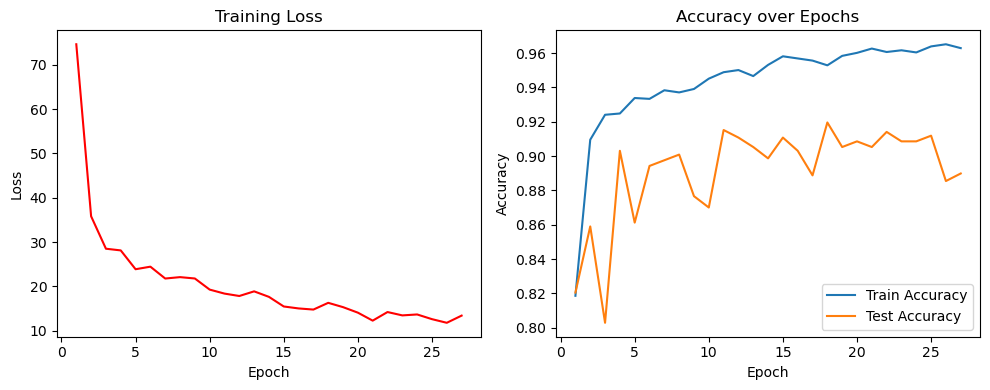

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(10, 4))

# 1. Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, label="Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

# 2. Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label="Train Accuracy")
plt.plot(epochs, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()
